# [Tutorial](https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/tree/main/tier_2/deep_learning)

# Surface Observation Postprocessing with Machine Learning

[![](https://img.shields.io/badge/open-colab-yellow)](https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_2/deep_learning/Surface_Observation_Prediction_in_Tensorflow.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_2/deep_learning/Surface_Observation_Prediction_in_Tensorflow.ipynb) [![Open%20In%20SageMaker%20Studio%20Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_2/deep_learning/Surface_Observation_Prediction_in_Tensorflow.ipynb) [![Launch%20in%20Deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https%3A%2F%2Fgithub.com%2Fecmwf-projects%2Fmooc-machine-learning-weather-climate%2Fblob%2Fmain%2Ftier_2/deep_learning%2FSurface_Observation_Prediction_in_Tensorflow.ipynb)

Surface observation processing refers to the process of collecting and analyzing weather observations taken at the Earth's surface by weather stations and other observing platforms. This typically includes measuring temperature, humidity, wind speed and direction, precipitation, and other meteorological variables. The observations are then used to produce weather forecasts and warnings, as well as to analyze and understand weather patterns. The process typically involves quality control checks to ensure the observations are accurate and reliable, as well as the use of automated systems to process and disseminate the observations in near real-time.

Surface observation processing is the process of collecting and analyzing weather information taken at ground level by weather stations and other observing platforms. These measurements include temperature, humidity, wind speed and direction, and precipitation. From this information, we can create weather forecasts and warnings and understand weather patterns.

Machine learning can be applied in surface observation processing in several ways. One way is to use machine learning algorithms to help improve the accuracy of forecasts by analyzing large amounts of historical weather data. The algorithms can make more accurate predictions about future weather by learning from past weather patterns. Another way machine learning can be applied is in the quality control of the observations. Machine learning models can be trained to identify and flag any observations that may be incorrect or unreliable. This quality control can help ensure that only the most accurate and reliable weather information is used for forecasts and other purposes.

In addition, Machine learning can be used to automate the process of surface observation processing, allowing the system to run more efficiently and quickly. This can help produce forecasts and warnings more quickly and with higher accuracy, providing more detailed and accurate information to the public.

Overall, the use of Machine learning in surface observation processing can help improve the accuracy and speed of weather forecasting, and provide more detailed and accurate information to the public.

In this notebooks, we are experimenting with deep learning techniques to solve a real-world problem that is relatively simple. The goal is to improve the temperature forecast of the ECMWF Integrated Forecast System (IFS) by using a technique called postprocessing.

Specifically, we are trying to predict the difference between the temperature observed at a weather station and the temperature forecasted by the IFS at the closest point on the grid to the station. To achieve this, we will look at several different predictors based on physical principles.

We will also get to explore several physically motivated predictors.

_An example of using machine learning to model weather forecast error based on work of Matthew Chantry and Fenwick Cooper as part of work funded by [IFAB](https://www.ifabfoundation.org/). Modified by Jesper Dramsch for the [MOOC Machine Learning in Weather & Climate](https://ecmwf.int/mlwc-mooc) brough to you by ECMWF in partnership with IFAB._

## Setting up the Notebook

First, we need to install the necessary packages using `pip`.

We are using Climetlab to load our prepared dataset, which we need to install

### Data and Machine Learning Libraries

Depending on the compute platform you are using, you may want to install the following packages in addition. These come pre-installed on some online environments like Google Colab, but not on all:

- numpy
- matplotlib
- scikit-learn
- tensorflow

We added those to the `requirements.txt` for your convenience. If you're trying this exercise locally on Windows, it may be easier installing the libraries with `conda`. Pytorch has a guide to [install locally here](https://pytorch.org/get-started/locally/) and Tensorflow has a guide to [install locally here](https://www.tensorflow.org/install/pip), which may differ from they minimal code below.

In [3]:
!pip install "climetlab-mltc-surface-observation-postprocessing>=0.3.0" --quiet

# !pip install numpy matplotlib scikit-learn  --quiet

# Tensorflow
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0 -yq
# !pip install tensorflow  --quiet

We will be using some tools that are commonly used in machine learning. 

Even though some of the mathematical concepts behind these tools are simple, it's often better to use pre-existing tools that have been tested and refined by others. This will save us time and make our analysis more reliable.

<div class="alert alert-block alert-info">
<b>Overview:</b> Numpy is the numerical Python library that is the de facto standard in dealing with scientific data in n-dimensional arrays
Matplotlib is a plotting library that can be used to create static, animated, and interactive visualizations of data.
Scikit-learn is a machine learning library for Python that provides simple and efficient tools for classic machine learning.
Tensorflow is a library for developing and deploying machine learning models, particularly neural networks.
Pytorch is a library for developing and deploying machine learning models, particularly deep learning models.</div>

In [4]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# CliMetLab will be used to manage the data loading.
import climetlab as cml

# Import a tool for helping make figures
from climetlab_mltc_surface_observation_postprocessing.utils import imgBufferFromVectors


## Loading the Data

We will be loading a list that contains the errors of temperature forecasts made by the high-resolution forecast system of the European Centre for Medium-Range Weather Forecasts (ECMWF) for a 36-hour period. These forecasts will be compared with temperature measurements taken from about 8000 weather stations located around the world.

<div class="alert alert-block alert-info"><strong>Note:</strong> It's important to note that the dataset we're using has already gone through a crucial step of preparation known as data preprocessing. This means that any data that could be considered invalid or unreliable has already been removed. For example, data from weather stations with inconsistent measurement locations, duplicate values, or values that are physically impossible (such as temperatures over 100 degrees Celsius) have been removed. If you're starting a new project, this step of cleaning the data is essential.</div>

In [5]:
forecast_error = cml.load_dataset("mltc-surface-observation-postprocessing", field="forecast_error").to_numpy()


By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/mchantry/climetlab-mltc-sop/blob/main/LICENSE. If you do not agree with such terms, do not download the data. 


forecast_error.csv:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

We have a hypothesis that the errors in the forecast can be easily explained by the time of day the measurements were taken. To test this, we will load the local time of day for when the measurements were recorded.

In [6]:
time_of_day = cml.load_dataset("mltc-surface-observation-postprocessing", field="time_of_day").to_numpy()


time_of_day.csv:   0%|          | 0.00/92.9M [00:00<?, ?B/s]

Later we will add in the soil temperature, so we'll load this here to have the data loading step complete.

In [7]:
soil_temperature = cml.load_dataset("mltc-surface-observation-postprocessing", field="soil_temperature").to_numpy()


soil_temperature.csv:   0%|          | 0.00/87.8M [00:00<?, ?B/s]

#### <span style='color:blue'>For quiz</span>

In [23]:
print('Range of the soil moisture: ', min(soil_temperature), max(soil_temperature))

Range of the soil moisture:  [-57.84999084] [63.01000977]


## Data Splitting

We will be dividing the data used to make predictions and the data used to predict into two separate groups: training and testing. The training group will consist of 80% of the data and the testing group will consist of 20% of the data. This is done randomly, so that the data in each group is representative of the overall dataset.

It's worth noting that the data has already been anonymized, so we can't use information about the weather stations or the time the measurements were taken to make sure that the data subsets are independent. If we had more metadata, we could use the methods we learned earlier to ensure that the data subsets are not dependent on each other.

We use the function "train_test_split" from the scikit-learn library.

The function takes an arbitrary number of inputs to split. Here we provide 3 inputs:

- `forecast_error`: it is the data containing errors in forecasted temperatures,
- `time_of_day`: it is the data containing the local time of day when the measurements were taken,
- `soil_temperature`: it is the data containing the soil temperature at the location where the measurements were taken.

The function also takes in two parameters:

- `test_size`: it specifies what proportion of the data should be in the testing group. In this case, it is set to 0.2, which means that 20% of the data will be in the testing group and 80% of the data will be in the training group.
- `random_state`: it is used for initializing the random number generator and get the same split each time the script is run. Here it is set to `42`, which is an arbitrary number.

The function returns 6 outputs:

- `forecast_error_train`: it is the data containing errors in forecasted temperatures that will be used for training,
- `forecast_error_test`: it is the data containing errors in forecasted temperatures that will be used for testing,
- `time_of_day_train`: it is the data containing the local time of day when the measurements were taken that will be used for training,
- `time_of_day_test`: it is the data containing the local time of day when the measurements were taken that will be used for testing,
- `soil_temperature_train`: it is the data containing the soil temperature at the location where the measurements were taken that will be used for training,
- `soil_temperature_test`: it is the data containing the soil temperature at the location where the measurements were taken that will be used for testing.

In summary, this code is splitting up the data into training and testing groups, using 80% of the data for training and 20% for testing. And it will be done in a random way and keep the same split each time the script is run by setting random_state to 42.

In [8]:
(
    forecast_error_train,
    forecast_error_test,
    time_of_day_train,
    time_of_day_test,
    soil_temperature_train,
    soil_temperature_test,
) = train_test_split(
    forecast_error,
    time_of_day,
    soil_temperature,
    test_size=0.2,
    random_state=42,
)


## Data Preprocessing

The next step is to standardize the data. This is an important step that helps to prepare the data for training a neural network, especially in larger problems. To standardize the data, we will be using a method called `StandardScaler` method from scikit-learn library. This method divides each data point by the mean and standard deviation of the training dataset. By doing this, it ensures that the data has a mean of 0 and a standard deviation of 1.

The code creates an instance of the `StandardScaler` class, and assigns it to the variable "scaler". Then we use the `fit()` method of this scaler object, which calculates the mean and variance of the `time_of_day_train` data. Note that we fit this object on the training data only, to avoid cheating and accidentally creating a model that seems like it works better than it actually does.

We apply the transformation to `time_of_day_train` data and creates a new variable `time_of_day_train_norm` which contains the standardized data.

The next line of code applies the same transformation to `time_of_day_test` data and creates a new variable `time_of_day_test_norm` which contains the standardized test data. Note that this only applies the standardization and doesn't learn from the test data, which is valid. This is one of the big benefits of using the `StandardScaler` object.

In summary, this code is standardizing the `time_of_day` data by calculating the mean and variance of the training data and then dividing the training and testing data by those values resulting in a new set of data with mean = 0 and variance = 1.

It's worth noting that there are other ways to prepare data for a neural network, and sometimes a different approach may be more appropriate. For example, when working with precipitation data, it may be more appropriate to use a log transform instead of standardizing the data.

In [9]:
scaler = StandardScaler()
scaler.fit(time_of_day_train)
print("Mean:", scaler.mean_, ", Variance:", scaler.var_)

time_of_day_train_norm = scaler.transform(time_of_day_train)
time_of_day_test_norm = scaler.transform(time_of_day_test)


Mean: [13.66310873] , Variance: [25.66713122]


## Model Building

In Tensorflow / Keras we have multiple ways to build a neural network. 

Two of these approaches will be presented below, namely the sequential and the functional approach.

This code defines two functions: "fullyconnected_sequential" and "fullyconnected_functional". Both functions create a model with a similar structure: it starts with an input layer, followed by several dense layers, and ends with an output layer. 

But first we import the necessary layers from the tensorflow library:

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential


### Sequential Model

The simplest is the sequential approach here we write a function `fullyconnected_sequential` which is used to build a neural network using the Keras library with a sequential approach. The function takes several parameters:

- `input_shape`: an integer representing the number of predictors.
- `width`: an integer representing how wide the layers should be.
- `depth`: an integer representing how many layers the network should have.
- `activation`: a string representing the non-linear activation function to use (e.g. 'relu', 'sigmoid', etc.).
- `learning_rate`: a float representing the learning rate of the optimizer (default value is 10^-3).
- `final_activation`: a string representing the activation function for the final layer(default value is 'linear').

The function starts by creating a Sequential model object, then it adds an input layer to the model, specifying the shape of the inputs expected input. Next, it stacks on depth number of consecutive dense layers, applying the activation function specified in the "activation" parameter after each Dense block. Then, it adds an output layer to the model, specifying that it should predict 1 variable and using a 'linear' activation function so as not to constrain the output. It then specifies the optimizer to use (Adam optimizer) and the learning rate. Finally, it compiles the model by specifying the loss function to minimize (mean squared error). The function returns the model after displaying the summary of the model.

In [11]:
def fullyconnected_sequential(
    input_shape: int,  # How many predictors?
    width: int,  # How wide should the layers be?
    depth: int,  # How many layers?
    activation: str,  # What nonlinearity to use?
    learning_rate=10**(-3),  # What learning rate?
    final_activation: str = "linear",  # Final activation
):
    # Create a model object
    model = Sequential()

    # Then just stack layers on top of one another
    # the first specifies the shape of the inputs expected input
    model.add(Input(input_shape, name="Inputs"))

    # Then we stack on depth number of consectutive dense layers
    # To write more compact code we can include the activation
    # function we want to apply after each Dense block in the
    # call itself.
    for i in range(depth):
        model.add(Dense(width, activation=activation))

    # Finally we add an output layer, we want to predict
    # 1 variable, and we will probably use a linear output
    # layer, so we don't constrain the output
    model.add(Dense(1, activation=final_activation))

    # Next we need to specify the optimiser we want to use and what learning rate to use
    opt = Adam(learning_rate)

    # Finally we compile the model, specifying the loss we want to minimise
    model.compile(loss="mse", optimizer=opt)

    # Afterwards we can summarise the model to see the shapes
    model.summary()
    return model


### Functional Model

For more advanced architectures, it's good to use the functional approach to writing networks. This is very similar to the syntax of Pytorch.

Here we stitch together a model, by passing one layer into the next layer. 

This code defines a function `fullyconnected_functional`. The function takes several parameters:

- `input_shape`: an integer representing the number of predictors.
- `width`: an integer representing how wide the layers should be.
- `depth`: an integer representing how many layers the network should have.
- `activation`: a string representing the non-linear activation to use (e.g. 'relu', 'sigmoid', etc.).
- `learning_rate`: a float representing the learning rate of the optimizer (default value is 10^-3).
- `final_activation`: a string representing the activation function for the final layer(default value is 'linear').

The function starts by creating an input layer, and then assigns it to a variable "inputs" and another variable "hidden". Then, we repeatedly stitch a new Dense layer to the object "hidden" for the number of times specified in the "depth" parameter. This adds another layer onto the stack each time. Next, we add the output layer to the model, specifying that it should predict 1 variable and using a 'linear' activation function so as not to constrain the output. It then creates the model by specifying the input layers and output layers, this approach allows to create a model with multiple inputs and outputs if appropriate for the problem. Finally, it specifies the optimizer to use (Adam optimizer) and the learning rate, compiles the model by specifying the loss function to minimize (mean squared error) and displays the summary of the model and returns the model.

In this simple model, there are few benefits to this approach, however, on more intricate networks, the enables forking and merging of paths within the network and even using multiple inputs and outputs.

In [12]:
def fullyconnected_functional(
    input_shape: int, width: int, depth: int, activation: str, learning_rate=10**(-3), final_activation: str = "linear"
):
    # First we create an input layer
    inputs = Input(input_shape, name="Inputs")

    # Pass it to the hidden variable we will reuse
    hidden = inputs

    for i in range(depth):
        # Now we repeatedly apply a Dense layer to the object each time this adds another layer onto the stack
        hidden = Dense(width, activation=activation)(hidden)

    # Finally stitch on the output layer
    output = Dense(1, activation="linear")(hidden)

    # And the model itself is created by specifying the input layers and output layers.
    model = Model(inputs=inputs, outputs=output)

    # Next we need to specify the optimiser we want to use and what learning rate to use
    opt = Adam(learning_rate)

    # Finally we compile the model, specifying the loss we want to minimise
    model.compile(loss="mse", optimizer=opt)

    # Afterwards we can summarise the model to see the shapes
    model.summary()
    return model


#### Adam Optimiser

When training a neural network, we use an optimization algorithm to adjust the parameters of the model in order to minimize the loss function. Notice that the optimiser we use is called `Adam` instead of the classic gradient descent algorithm described during the lessons.

Gradient descent is a simple optimization algorithm that updates the model's parameters by taking a step in the direction of the negative gradient of the loss function. The step size is determined by a learning rate parameter, which controls how large the step should be. Gradient descent can work well for simple models, but can be slow to converge for more complex models.

Adam, on the other hand, is a more advanced optimization algorithm that is based on gradient descent. It uses an adaptive learning rate, which means that the step size is adjusted for each parameter based on the historical gradient information. This can help the optimization converge faster and more efficiently. Adam also includes additional features such as momentum and RMSprop, which can further improve the optimization process. This makes Adam more similar to the Conjuage Gradient method in classic numerical optimisation. Choosing Adam can improve the optimization process and make it converge faster and more efficiently.

#### Model Compiler

Also note that we have to compile these models. Something that is quite uncommon in Python. Compiling a model in TensorFlow is necessary to specify the loss function, optimizer and metrics that are used to train and evaluate the model that is defined on a computational graph. It also sets the model in a state ready to be used for training and inference and allows integration with other high-level libraries like Keras we use here.

### Creating the Model
Create neural network object you can use either of the functions we defined above


Try changing the depth and see what the summary says:

<div class="alert alert-block alert-warning"> 
<b>Alternative:</b><code>
model = fullyconnected_sequential(
    time_of_day_train_norm.shape[1], depth=3, width=32, activation="tanh", learning_rate=10**(-3)
)</code>
</div>

In [13]:
model = fullyconnected_functional(
    time_of_day_train_norm.shape[1], depth=3, width=32, activation="tanh", learning_rate=10**(-3)
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
_________________________________________________________________


<div class="alert alert-block alert-info">
<b>Note:</b> We have 2000 parameters to learn. This is many fewer than the number of examples, so we should not be too worried about overfitting.</div>


## Model training

The `fit` function implements the training loop for a model in TensorFlow. 

The first two arguments passed to the `fit` function are the training data and labels. In this case, the training data is `time_of_day_train_norm` and the labels are `forecast_error_train`. These are the inputs and outputs that the model will use to learn during training.

The `batch_size` argument specifies the number of samples per gradient update. The `epochs` argument is the number of times the model will cycle through the data.

Once the training is done, the model will be optimized to make predictions on new data with the same features.

### Validation Strategies

We learned that we can only use the test data for a final evaluation of the model performance after we are done tweaking the model.

However, we need data to evaluate the neural network after each epoch, to see how well the training is doing on unseen data. Keras has implemented the `validation_split`, which takes a percentage of the data automatically as a validation holdout.

Alternatively, we can user the argument `validation_data` which provides explicit data to evaluate the performance of the model during training. It is used to test the model during the training process and make sure it's not overfitting. In this case, we split the training data again to get the validation data as `time_of_day_val_norm` and the validation labels are `forecast_error_val`. Note that this data will perform slightly better, since it's normalised with the original training data. Ideally, we would get a validation holdout before standardization, in this particular case, we can get away with it to compare the performance of the `validation_split` vs. the `validation_data`.

In [14]:
model.fit(
    time_of_day_train_norm,
    forecast_error_train,
    validation_split=0.15,
    batch_size=128,
    epochs=3,
)


Epoch 1/3
27973/27973 [==============================] - 102s 3ms/step - loss: 4.8962 - val_loss: 4.8868
Epoch 2/3
27973/27973 [==============================] - 99s 4ms/step - loss: 4.8754 - val_loss: 4.8834
Epoch 3/3
27973/27973 [==============================] - 96s 3ms/step - loss: 4.8723 - val_loss: 4.8874


In this problem we have a large amount of data and a relatively small number of parameters to train, we therefore see that the model converges very quickly, with the loss decreasing little after the first epoch.

We'll use the `train_test_split`function from scikit-learn again to subdivide the training data into an extra validation holdout set:

In [15]:
time_of_day_train_small_norm, time_of_day_val_norm, forecast_error_train_small, forecast_error_val = train_test_split(
    time_of_day_train_norm, forecast_error_train, test_size=0.15, random_state=42
)

model.fit(
    time_of_day_train_small_norm,
    forecast_error_train_small,
    validation_data=(time_of_day_val_norm, forecast_error_val),
    batch_size=128,
    epochs=3,
)


Epoch 1/3
27973/27973 [==============================] - 96s 3ms/step - loss: 4.8721 - val_loss: 4.8715
Epoch 2/3
27973/27973 [==============================] - 98s 3ms/step - loss: 4.8712 - val_loss: 4.8742
Epoch 3/3
27973/27973 [==============================] - 99s 4ms/step - loss: 4.8701 - val_loss: 4.8742


In other problems it may take far longer training to reach this point, or even be impossible if a network is not appropriate for the data provided.

## Model Evaluation

Finally we can do a numerical evaluation how well the model performs on unseen data.

Purely, as a teaching device, we'll also evaluate the model on training data. This number is relatively meaningless standing by itself, as the model will always perform on training data as long as the model converged. The validation data is unseen as training, but was involved in the optimization process, which can have indirect optimization consequences, by us adjusting the architecture manually and generally making design choices based on the validation results.

But it's good to learn, why we test on actual unseen data and use the training value as the lower bound for our expectations of the final evaluation of the test data.

In [16]:
train_loss = model.evaluate(time_of_day_train_norm, forecast_error_train)
print("Training Mean Squared Error:", train_loss)

val_loss = model.evaluate(time_of_day_val_norm, forecast_error_val)
print("Validation  Mean Squared Error:", val_loss)


131638/131638 [==============================] - 255s 2ms/step - loss: 4.8701
Training Mean Squared Error: 4.87007999420166
19746/19746 [==============================] - 38s 2ms/step - loss: 4.8742
Validation  Mean Squared Error: 4.874156475067139


Here we see the actual performance of our model compared based on true unseen data.

In [17]:
test_loss = model.evaluate(time_of_day_test_norm, forecast_error_test)
print("Test  Mean Squared Error:", test_loss)


32910/32910 [==============================] - 64s 2ms/step - loss: 4.8762
Test  Mean Squared Error: 4.8761796951293945


### Visualization for Evaluation

We can create some fake data to cover the entire day and get predictions to visualize the entire space of the data. 

This is not always possible, but that's what we have this tutorial data for to gain an intuitive understanding of the methods we apply. This creates an array of time of day values spanning from 0 to 24, with a step of 0.001. This is a full range of time of day values that we want to make predictions on. The array is then reshaped to have a single axis, this is done with the `[..., np.newaxis]` slice.

Then we apply the same standardization procedure (using the fitted `scaler` object) on the full range of time of day values as the one used on the training and test data, to ensure that the new data has the same scale as the data the model was trained on.

Finally, the code uses the `predict()` function to make predictions on the normalized full range of time of day values. The predict function returns an array of predicted forecast errors, one for each input time of day value. The variable `forecast_error_full_range_predicted` stores these prediction.

In [18]:
time_of_day_full_range = np.arange(0, 24, 0.001)[..., np.newaxis]
time_of_day_full_range_norm = scaler.transform(time_of_day_full_range)
forecast_error_full_range_predicted = model.predict(time_of_day_full_range_norm)


750/750 [==============================] - 1s 1ms/step


Then we create an image of time of day values against forecast error values. The image is created by using a function called `imgBufferFromVectors` which takes a set of `x` and `y` values and creates an image.

The function takes these arguments:

- `time_of_day_test`: the x values, representing the time of day
- `forecast_error_test`: the y values, representing the forecast error
- `nx`: the number of pixels in the x-axis of the image
- `ny`: the number of pixels in the y-axis of the image
- `extent`: the range of values to be plotted in the image, if empty it will use the min and max of the x and y values.
- `calc_average`: a boolean flag indicating whether to calculate the average of the input values or not.

The function then returns the image as a buffer, the extent of the axis and the count of values in the image.

In [19]:
tod_buffer, ax_extent, count = imgBufferFromVectors(
    time_of_day_test, forecast_error_test, nx=256, ny=256, extent=[], calc_average=False
)


Let's plot the number of measurements at each time of day against the forecast error.

The red line shows the best fit.

<div class="alert alert-block alert-info"> <b>Note:</b> The model (red line) is better than nothing, but does not account for the variation in 2m temperature error at single time of day (eg. at 14:00). Another predictor is required. We try using the soil temperature. In comparison to the regression model, the result of the neural etwork is less smooth which can be a good OR a bad thing.</div>

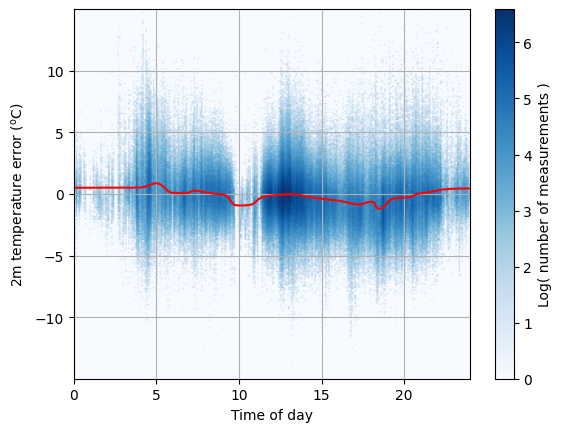

In [20]:
plt.imshow(np.log((count == 0.0) + count), cmap="Blues", origin="lower", extent=ax_extent, aspect="auto")

plt.xlim([0, 24])
plt.grid()
plt.xlabel("Time of day")
plt.ylabel("2m temperature error ($^\mathrm{o}$C)")
cb = plt.colorbar()
cb.set_label("Log( number of measurements )")

# Line of best fit
plt.plot(time_of_day_full_range, forecast_error_full_range_predicted, "red")

plt.show()


## Improving the Model

Now we can start to play around.

Let's add more predictors. 

We will add a second predictor, the model soil temperature. As we will see below, there is a complex structure in the pattern of forecast error in the 2D space of time of day & soil temperature. 

How well can the model learn this?

### Visualize the Soil Temperature Data

This code is plotting a 2D histogram of the relationship between forecast error, soil temperature and time of day. 

Notice how blue shows that the observation is warmer than the forecast and red shows that forecast is warmer than the observation.

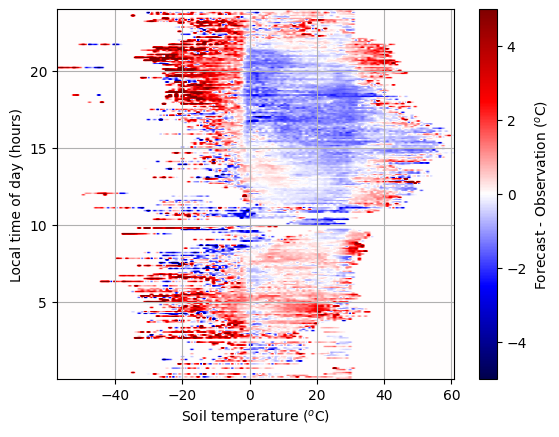

In [21]:
# Make image of the error with the new predictor
buffer, ax_extent, count = imgBufferFromVectors(
    soil_temperature_test, time_of_day_test, forecast_error_test, 128, 256, extent=[], calc_average=True
)

# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap="seismic", origin="lower", extent=ax_extent, aspect="auto")

plt.grid()
plt.xlabel("Soil temperature ($^o$C)")
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label("Forecast - Observation ($^o$C)")

plt.show()


In the image above we see clear structure, where the in evening the forecast is too warm if the soil is frozen and too cold if the soil is not.

Can we learn a good representation of this error pattern?

### Training a new model

We'll train a neural network model using two predictors, time of day and soil temperature. 

The data for the two predictors is first concatenated and then standardized using `StandardScaler` again. Then we construct a functional model with depth and width of 3 and 32 respectively, using `tanh` activation function to mix things up and train.

<div class="alert alert-block alert-warning">Again, this may take a couple of minutes</div>

In [22]:
# Create the input features
X_train = np.concatenate([time_of_day_train, soil_temperature_train], axis=-1)
X_test = np.concatenate([time_of_day_test, soil_temperature_test], axis=-1)

# Standardise the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Construct a model, this time with 2 predictors
model_with_soil = fullyconnected_functional(
    X_train.shape[-1], depth=3, width=32, activation="tanh", learning_rate=10**(-3)
)

# Alternative activation functions are tanh, sigmoid, softmax, relu, softplus...

# Train the model using the data
model_with_soil.fit(X_train, forecast_error_train, validation_split=0.15, batch_size=128, epochs=3)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 32)                96        
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
27973/27973 [==============================] - 

### Evaluating the New Model

Let's do some evaluation on the unseen test data!

We'll calculate the mean absolute error and the RMSE of the uncorrected forecast and the corrected forecast.

In [24]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0 * forecast_error_test
print("Mean Absolute Error Uncorrected:", metrics.mean_absolute_error(zero_test, forecast_error_test))
print("Root Mean Squared Error Uncorrected:", np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

forecast_corrected = forecast_error_test - model_with_soil.predict(X_test)

print("Mean Absolute Error Corrected:", metrics.mean_absolute_error(zero_test, forecast_corrected))
print("Root Mean Squared Error Corrected:", np.sqrt(metrics.mean_squared_error(zero_test, forecast_corrected)))


Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
32910/32910 [==============================] - 49s 1ms/step
Mean Absolute Error Corrected: 1.5582476234714175
Root Mean Squared Error Corrected: 2.1594936249405094


By using two predictors we can impove the forecast of 2m-temperature by ~0.1C.

#### Visual Evaluation

Let's see how the model corrects the forecast across the full 2D space.

We'll run the trained model over a range of values for the input variables `soil_temperature` and `time_of_day`. 

It first defines the range of values for these variables using `nx` and `ny`, which are the dimensions of the input buffer, and the `ax_extent` which is the range of values observed in the data. Then it creates the input data by stacking the meshgrid of these variable ranges using `np.meshgrid`, and transforms this input data using the `scaler` that was fit earlier on the training data. Then we predict the output using this input data and reshapes this output back to 2D plot using `raw_pred.reshape(input_buffer.shape[:-1])` for us to plot!

In [25]:
# Run the fit model over the plot domain

# The x and y values of each point in the plot image, this covers
# the range of data observed in the data
nx = buffer.shape[0]
ny = buffer.shape[1]
x_st = np.linspace(ax_extent[0], ax_extent[1], nx)  # Represents soil_temperature
y_tod = np.linspace(ax_extent[2], ax_extent[3], ny)  # Represents time_of_day

# Create the input data
input_buffer = np.stack(np.meshgrid(y_tod, x_st), axis=-1)
X_plot = scaler.transform(input_buffer.reshape(-1, X_train.shape[-1]))

# Predict and reshape prediction back to 2D plot
raw_pred = model_with_soil.predict(X_plot)
model_buffer = raw_pred.reshape(input_buffer.shape[:-1])


1024/1024 [==============================] - 1s 1ms/step


Let's compare the images!

Notice that we're fixing the range of the plot between -5 and 5 to make these plots intuitively comparable.

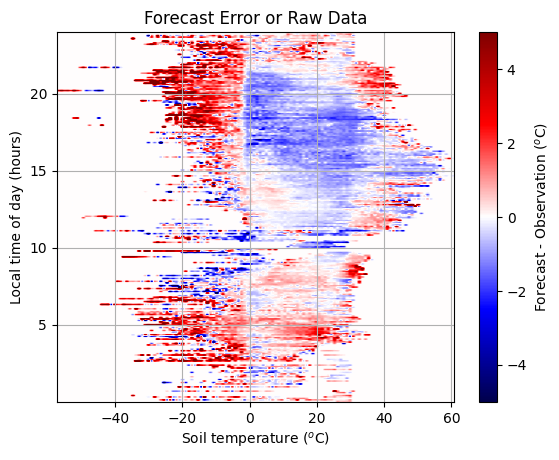

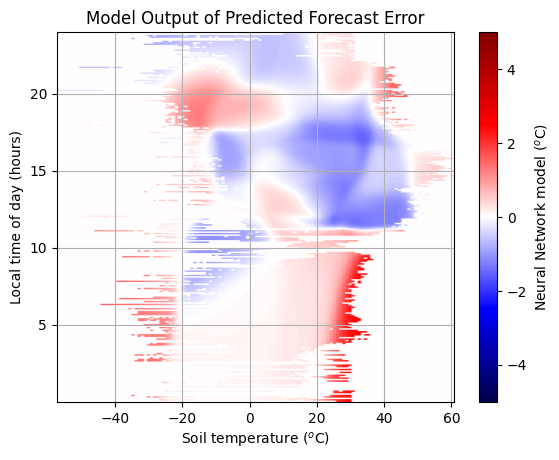

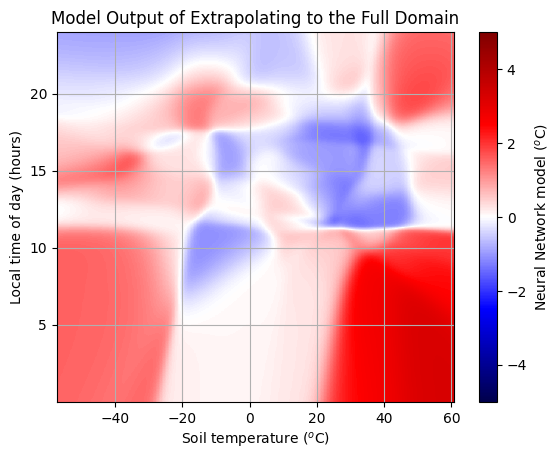

In [26]:
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap="seismic", origin="lower", extent=ax_extent, aspect="auto")

plt.grid()
plt.title("Forecast Error or Raw Data")
plt.xlabel("Soil temperature ($^o$C)")
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label("Forecast - Observation ($^o$C)")

plt.show()

# Plot the model output where we have data
plt.imshow(
    (model_buffer) * (count > 0), vmin=-5, vmax=5, cmap="seismic", origin="lower", extent=ax_extent, aspect="auto"
)

plt.grid()
plt.title("Model Output of Predicted Forecast Error")
plt.xlabel("Soil temperature ($^o$C)")
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label("Neural Network model ($^o$C)")

plt.show()

# Plot the model over the whole domain
plt.imshow(model_buffer, vmin=-5, vmax=5, cmap="seismic", origin="lower", extent=ax_extent, aspect="auto")

plt.grid()
plt.title("Model Output of Extrapolating to the Full Domain")
plt.xlabel("Soil temperature ($^o$C)")
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label("Neural Network model ($^o$C)")

plt.show()


## Conclusion

As we add more predictors and complexity to our model, it becomes better and better. But, our measurements of the forecast error are not perfect. There is some noise. We don't want our model to capture this. But an overly complex model will. We need a simpler model, or more data. Fitting a model that is too complex for the data is causes overfitting. 

Here we have a large number of observations and still relatively small number of free parameters, so overfitting is unlikely. We see that during training our errors on the training & testing dataset are comparable.

Away from where data has been provided the model does not have constraints. We should not trust this part of the space without additional validation.

We also see different model corrections for hour 23 and hour 0, when these should be closely correlated, as they're mere seconds away from each other.


# Exercises

1. Can you beat these predictions by changing the model architecture?

Play around with activations, depth, width, learning rate of the neural network.

2. Is there a way of building in any prior knowledge to even this simple setup?

Perhaps you can encode the fact that 0 hour follows 24? Does this help the prediction?

Now that you've had a proper introduction to deep learning, you may quench your curiosity and go back to the Weatherbench notebook from tier 1 to inspect a convolutional neural network.
